#### This data analysis was created by Ravisara (Ning) Wattana
##### Ph.D. candidate in the Osuji lab at the University of Pennsylvania

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.cm as cm
import mpltools.annotation as annotation
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import least_squares
from scipy.integrate import quad
from scipy.stats import linregress
from scipy.signal import argrelmax, argrelmin
from sklearn.metrics import r2_score
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import ListedColormap
from matplotlib.ticker import AutoMinorLocator
from matplotlib.legend_handler import HandlerTuple
from matplotlib.patches import PathPatch
from matplotlib.path import Path
from math import log as ln

In [2]:
plt.rcParams['font.family'] = 'Helvetica'

# Dynamic Light Scattering (DLS) and Depolarized Dynamic Light Scattering (DDLS) Measurements of anisotropic particles & Analysis of DDLS data 

In [3]:
AuNRs = pd.read_csv('/Users/ningravi/Desktop/Python/UV Vis/20240716/Au NRs.csv')

wavelength_AuNRs_0p01OD = pd.to_numeric(AuNRs.iloc[1:602, 0], errors='coerce')
abs_AuNRs_0p01OD = pd.to_numeric(AuNRs.iloc[1:602, 3], errors='coerce')

wavelength_AuNRs_0p1OD = pd.to_numeric(AuNRs.iloc[1:602, 4], errors='coerce')
abs_AuNRs_0p1OD = pd.to_numeric(AuNRs.iloc[1:602, 5], errors='coerce')

wavelength_AuNRs_0p5OD = pd.to_numeric(AuNRs.iloc[1:602, 6], errors='coerce')
abs_AuNRs_0p5OD = pd.to_numeric(AuNRs.iloc[1:602, 7], errors='coerce')

wavelength_AuNRs_1OD = pd.to_numeric(AuNRs.iloc[1:602, 8], errors='coerce')
abs_AuNRs_1OD = pd.to_numeric(AuNRs.iloc[1:602, 9], errors='coerce')

wavelength_AuNRs = [wavelength_AuNRs_0p01OD, wavelength_AuNRs_0p1OD, 
                    wavelength_AuNRs_0p5OD, wavelength_AuNRs_1OD]
abs_AuNRs = [abs_AuNRs_0p01OD, abs_AuNRs_0p1OD, 
             abs_AuNRs_0p5OD, abs_AuNRs_1OD]
label_AuNRs = ['0.01', ' 0.1', ' 0.5', '  1']

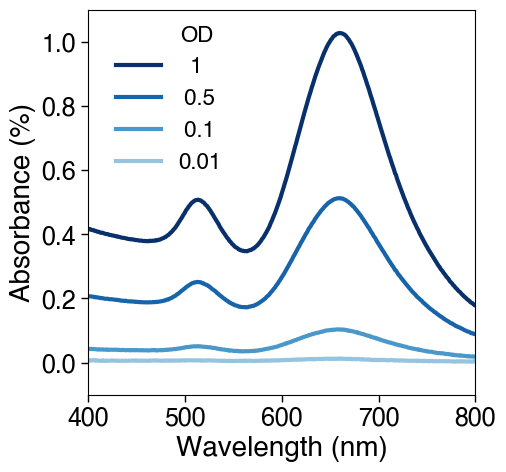

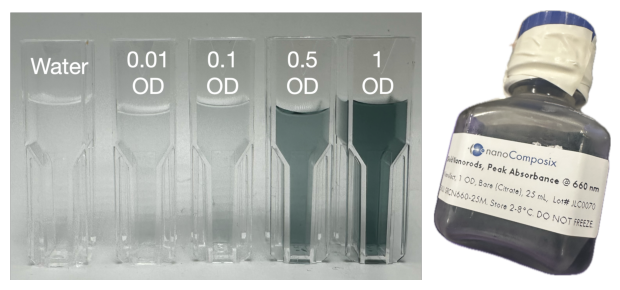

In [4]:
cmap_full = plt.get_cmap('Blues')
cmap = ListedColormap(cmap_full(np.linspace(0.4, 1, 100)))
colors = cmap([i / (len(wavelength_AuNRs) - 1) for i in range(len(wavelength_AuNRs))])

fig, ax = plt.subplots(figsize=(5, 5))
for i in range(len(wavelength_AuNRs)):
    ax.plot(wavelength_AuNRs[i], abs_AuNRs[i], label=f'{label_AuNRs[i]}', color=colors[i], linewidth=3)
ax.set_ylim(-0.1, 1.1)
ax.set_xlim(400, 800)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=16, loc=(0.05, 0.55), frameon=False)
ax.set_xlabel('Wavelength (nm)', fontsize=20)
ax.set_ylabel('Absorbance (%)', fontsize=20)
ax.tick_params(axis='both', which='both', width=1, length=5, labelsize=18)


plt.text(495, 1, 'OD', fontsize=16)
#plt.savefig("UV vis Au NPs.png", dpi=300, bbox_inches='tight', transparent=True)
plt.show()

img = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/AuNRs_UVVis.png')

aspect_ratio = img.shape[1] / img.shape[0]

fig, ax = plt.subplots(figsize=(6 * aspect_ratio, 6))

ax.imshow(img)
ax.axis('off')  
plt.subplots_adjust(left=0, right=0.45, top=1, bottom=0)

plt.show()

For anisotropic nanoparticles:

DLS (Polarized, vertical; VV – polarization // the incident E field):

$$
G_{VV} (\tau) = A_1 exp(-(\Gamma_t+\Gamma_r)\tau)+A_2 exp(-\Gamma_t \tau) + B
$$

$$
G_{VV} (\tau) = A_1 exp(-\Gamma_{mixed}\tau)+A_2 exp(-\Gamma_t \tau) + B
$$

DDLS (Depolarized, horizontal; VH – polarization | the incident E field):

$$
G_{VH} (\tau) = A_3 exp(-(\Gamma_t+\Gamma_r)\tau) + B'
$$
$$
G_{VH} (\tau) = A_3 exp(-\Gamma_{mixed}\tau) + B'
$$


In [5]:
# Import data from the DLS measurements of the 0.1OD AuNR suspensions
# Fit the data and obtain the fitted parameters

def gVV(tau, A1, A2, B, Gamma_t, delta):
    Gamma_mix = Gamma_t + np.abs(delta)  # Ensure Gamma_mix is always greater than Gamma_t
    return A1 * np.exp(-Gamma_mix * tau) + A2 * np.exp(-Gamma_t * tau) + B

def residuals(params, tau, data):
    A1, A2, B, Gamma_t, delta = params
    return np.sum((data - gVV(tau, A1, A2, B, Gamma_t, delta))**2)

def calculate_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

average_gammas_VV = []
std_gammas_VV = []
r_squared_values_VV = []
extended_x_values_VV = []
fitted_y_values_VV = []

angles = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

base_paths_VV = [
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 1/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 2/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 3/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 4/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 5/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 6/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 7/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 8/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 9/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 10/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 11/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Measurement 12/'
]

for ang, base_path in zip(angles, base_paths_VV):
    fitted_params_VV = []

    for i in range(1, 4):
        file_path = f'{base_path}Repetition{i}/Correlation Function.csv'
        df = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])

        lagtime_var = f'lagtime_Aunrods_{ang}_{i}_VV'
        lagtime_ms_var = f'lagtime_Aunrods_{ang}_ms_{i}_VV'
        corrfx_var = f'corrfx_Aunrods_{ang}_{i}_VV'

        globals()[lagtime_var] = df.iloc[:, 0]
        globals()[lagtime_ms_var] = globals()[lagtime_var] * 1000
        globals()[corrfx_var] = df.iloc[:, 1]

        # Define initial parameters and bounds
        initial_params = [1, 1, 1, 1, 1]
        bounds = [(0, np.inf), (0, np.inf), (0, np.inf), (0, np.inf), (-np.inf, np.inf)]

        # Define the constraint: Gamma_mix > Gamma_t
        cons = {'type': 'ineq', 'fun': lambda x: x[4] - x[3]}

        result = minimize(residuals, initial_params, args=(globals()[lagtime_ms_var], globals()[corrfx_var]), 
                          bounds=bounds, constraints=cons)

        fitted_params_VV.append(result.x)

        # Calculate the fitted y values and r_squared
        fitted_y = gVV(globals()[lagtime_ms_var], *result.x)
        r_squared = calculate_r_squared(globals()[corrfx_var], fitted_y)
        extended_x = np.linspace(globals()[lagtime_ms_var].min(), globals()[lagtime_ms_var].max(), 500)
        extended_y = gVV(extended_x, *result.x)

        r_squared_values_VV.append(r_squared)
        extended_x_values_VV.append(extended_x)
        fitted_y_values_VV.append(extended_y)

    params_df_VV = pd.DataFrame(fitted_params_VV, columns=['A1', 'A2', 'B', 'Gamma_t', 'Gamma_mix'])

    average_gamma_VV = params_df_VV['Gamma_t'].mean()
    std_gamma_VV = params_df_VV['Gamma_t'].std()

    average_gammas_VV.append(average_gamma_VV)
    std_gammas_VV.append(std_gamma_VV)

    print(f"Fitted parameters for angle {ang}:")
    print(params_df_VV)
    print(f"Average Gamma_t at {ang} degrees: {average_gamma_VV:.2f} 1/ms")
    print(f"R^2 for angle {ang}: {r_squared:.4f}\n")

Fitted parameters for angle 30:
         A1        A2         B   Gamma_t   Gamma_mix
0  0.617009  0.342370  0.000000  1.157409  249.406146
1  0.615490  0.352994  0.001697  1.215269  291.482711
2  0.619984  0.346653  0.000439  1.251822  296.590777
Average Gamma_t at 30 degrees: 1.21 1/ms
R^2 for angle 30: 0.9996

Fitted parameters for angle 40:
         A1        A2             B   Gamma_t   Gamma_mix
0  0.618009  0.356329  7.819948e-04  2.172559  301.352480
1  0.617376  0.353668  1.598845e-19  2.184309  302.263337
2  0.616334  0.356354  1.048351e-20  2.146343  303.258133
Average Gamma_t at 40 degrees: 2.17 1/ms
R^2 for angle 40: 0.9996

Fitted parameters for angle 50:
         A1        A2         B   Gamma_t   Gamma_mix
0  0.602185  0.348379  0.000000  3.318541  301.578350
1  0.602949  0.348979  0.000753  3.477418  310.580166
2  0.603544  0.349977  0.002470  3.373637  307.064493
Average Gamma_t at 50 degrees: 3.39 1/ms
R^2 for angle 50: 0.9997

Fitted parameters for angle 60:
       

In [6]:
# Import data from the DDLS measurements of the 0.1OD AuNR suspensions
# Fit the data and obtain the fitted parameters

def gVH(tau, A3, BB, Gamma_mix):
    return A3 * np.exp(-Gamma_mix * tau) + BB

def calculate_r_squared(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

average_gammas_VH = []
std_gammas_VH = []
r_squared_values_VH = []
extended_x_values_VH = []
fitted_y_values_VH = []

angles = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

base_paths_VH = [
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 1/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 2/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 3/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 4/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 5/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 6/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 7/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 8/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 9/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 10/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 11/',
    '/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Measurement 12/'
]

for ang, base_path in zip(angles, base_paths_VH):
    fitted_params_VH = []

    for i in range(1, 4):
        file_path = f'{base_path}Repetition{i}/Correlation Function.csv'
        df = pd.read_csv(file_path, header=None, skiprows=[0, 1, 2])

        lagtime_var = f'lagtime_Aunrods_{ang}_{i}_VH'
        lagtime_ms_var = f'lagtime_Aunrods_{ang}_ms_{i}_VH'
        corrfx_var = f'corrfx_Aunrods_{ang}_{i}_VH'

        globals()[lagtime_var] = df.iloc[:, 0]
        globals()[lagtime_ms_var] = globals()[lagtime_var] * 1000
        globals()[corrfx_var] = df.iloc[:, 1]

        # Define initial parameters and bounds
        p0 = [1, 1, 1]
        bounds = (0, np.inf)

        # Perform the fitting
        popt, _ = curve_fit(gVH, globals()[lagtime_ms_var], globals()[corrfx_var], p0=p0, bounds=bounds)

        fitted_params_VH.append(popt)

        # Calculate the fitted y values and r_squared
        fitted_y = gVH(globals()[lagtime_ms_var], *popt)
        r_squared = calculate_r_squared(globals()[corrfx_var], fitted_y)
        extended_x = np.linspace(globals()[lagtime_ms_var].min(), globals()[lagtime_ms_var].max(), 500)
        extended_y = gVH(extended_x, *popt)

        r_squared_values_VH.append(r_squared)
        extended_x_values_VH.append(extended_x)
        fitted_y_values_VH.append(extended_y)

    params_df_VH = pd.DataFrame(fitted_params_VH, columns=['A3', 'BB', 'Gamma_mix'])

    average_gamma_VH = params_df_VH['Gamma_mix'].mean()
    std_gamma_VH = params_df_VH['Gamma_mix'].std()

    average_gammas_VH.append(average_gamma_VH)
    std_gammas_VH.append(std_gamma_VH)

    print(f"Fitted parameters for angle {ang}:")
    print(params_df_VH)
    print(f"Average Gamma_mix at {ang} degrees: {average_gamma_VH:.2f} 1/ms")
    print(f"R^2 for angle {ang}: {r_squared:.4f}\n")


Fitted parameters for angle 30:
         A3        BB   Gamma_mix
0  0.977900  0.000687  511.362424
1  0.973424  0.000987  507.717043
2  0.974379  0.001009  508.805708
Average Gamma_mix at 30 degrees: 509.30 1/ms
R^2 for angle 30: 0.9997

Fitted parameters for angle 40:
         A3        BB   Gamma_mix
0  0.957325  0.000498  515.919668
1  0.960668  0.001127  514.854747
2  0.956375  0.001109  516.243124
Average Gamma_mix at 40 degrees: 515.67 1/ms
R^2 for angle 40: 0.9998

Fitted parameters for angle 50:
         A3        BB   Gamma_mix
0  0.963150  0.001242  522.281131
1  0.961259  0.000907  519.285812
2  0.964056  0.001063  521.136752
Average Gamma_mix at 50 degrees: 520.90 1/ms
R^2 for angle 50: 0.9998

Fitted parameters for angle 60:
         A3        BB   Gamma_mix
0  0.965865  0.000671  523.574807
1  0.962431  0.000905  521.649812
2  0.968090  0.000977  524.746885
Average Gamma_mix at 60 degrees: 523.32 1/ms
R^2 for angle 60: 0.9998

Fitted parameters for angle 70:
         A3 

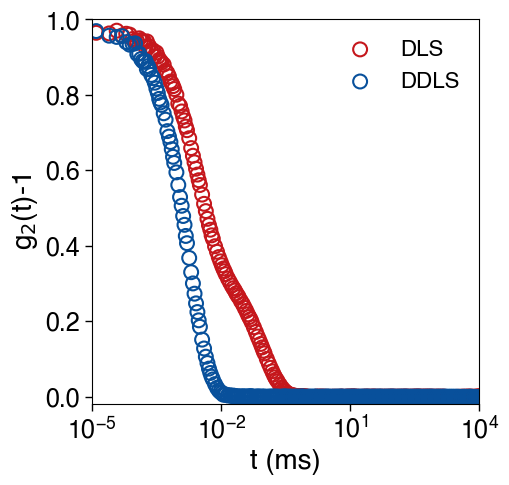

In [7]:
# Compare the dintinct features between the two measured modes

cmap_VV_0 = plt.get_cmap('Reds')
cmap_VV = ListedColormap(cmap_VV_0(np.linspace(0.2, 1.0, 100)))
cmap_VH_0 = plt.get_cmap('Blues')
cmap_VH = ListedColormap(cmap_VH_0(np.linspace(0.1, 1.2, 100)))

fig, ax = plt.subplots(figsize=(5, 5))

scatter1 = ax.scatter(lagtime_Aunrods_100_ms_2_VV, corrfx_Aunrods_100_2_VV, marker='o', facecolors=cmap_VV(0.7), edgecolors=cmap_VV(0.7), 
                          s=100, linewidths=1.5, label= 'DLS')
scatter1.set_facecolor('none') 
scatter2 = ax.scatter(lagtime_Aunrods_100_ms_2_VH, corrfx_Aunrods_100_2_VH, marker='o', facecolors=cmap_VH(0.7), edgecolors=cmap_VH(0.7), 
                          s=100, linewidths=1.5, label= 'DDLS')
scatter2.set_facecolor('none')

plt.xscale("log")
plt.xlabel('t (ms)', fontsize=20)
plt.ylabel('g$_2$(t)-1', fontsize=20)  
plt.legend(frameon=False, loc='best',fontsize=16)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
plt.xlim(1E-5, 1E4)
plt.ylim(-0.02, 1)
#plt.savefig("Correlation function VS lag time DLS vs DDLS at 80deg.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

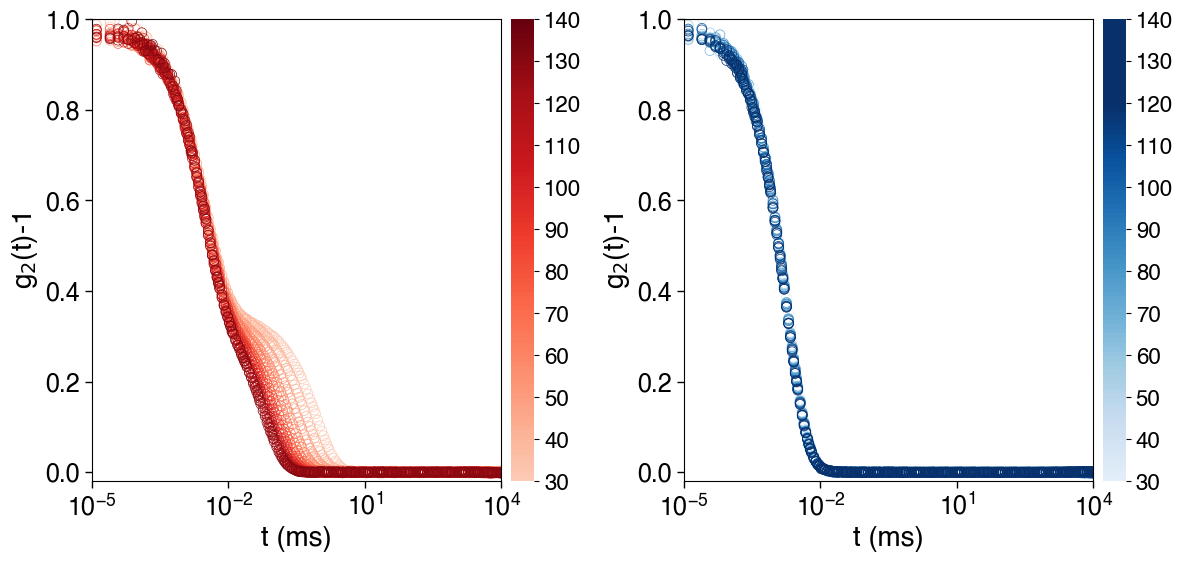

In [8]:
# Plot only one data set out of the three measured data sets at each angle 

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

angles = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140]

lagtime_VV = [globals()[f"lagtime_Aunrods_{angle}_ms_3_VV"] for angle in angles]
corrfx_VV = [globals()[f"corrfx_Aunrods_{angle}_3_VV"] for angle in angles]

lagtime_VH = [globals()[f"lagtime_Aunrods_{angle}_ms_3_VH"] for angle in angles]
corrfx_VH = [globals()[f"corrfx_Aunrods_{angle}_3_VH"] for angle in angles]


cmap_VV_0 = plt.get_cmap('Reds')
cmap_VV = ListedColormap(cmap_VV_0(np.linspace(0.2, 1.0, 100)))
cmap_VH_0 = plt.get_cmap('Blues')
cmap_VH = ListedColormap(cmap_VH_0(np.linspace(0.1, 1.2, 100)))

ax1 = axs[0]
for idx, (x, y, label) in enumerate(zip(lagtime_VV, corrfx_VV, angles)):
    c = cmap_VV(float(idx) / len(lagtime_VV))
    scatter1 = ax1.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')
    
sm_VV = plt.cm.ScalarMappable(cmap=cmap_VV)
sm_VV.set_array([])
cbar_VV = plt.colorbar(sm_VV, ax=ax1, orientation='vertical', pad=0.02)
cbar_VV.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VV.set_ticks(ticks)
cbar_VV.set_ticklabels(tick_labels, fontsize=16)

ax2 = axs[1]
for idx, (x, y, label) in enumerate(zip(lagtime_VH, corrfx_VH, angles)):
    c = cmap_VH(float(idx) / len(lagtime_VH))
    scatter1 = ax2.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')

sm_VH = plt.cm.ScalarMappable(cmap=cmap_VH)
sm_VH.set_array([])
cbar_VH = plt.colorbar(sm_VH, ax=ax2, orientation='vertical', pad=0.02)
cbar_VH.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VH.set_ticks(ticks)
cbar_VH.set_ticklabels(tick_labels, fontsize=16)

for ax in axs.flat:
    ax.set_xscale("log")
    ax.set_xlabel('t (ms)', fontsize=20)
    ax.set_ylabel('g$_2$(t)-1', fontsize=20)
    #ax.legend(frameon=False, loc='best', fontsize=16)
    ax.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.set_xlim(1E-5, 1E4)
    ax.set_ylim(-0.02, 1)
#plt.savefig("Correlation function VS lag time DLS vs DDLS.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

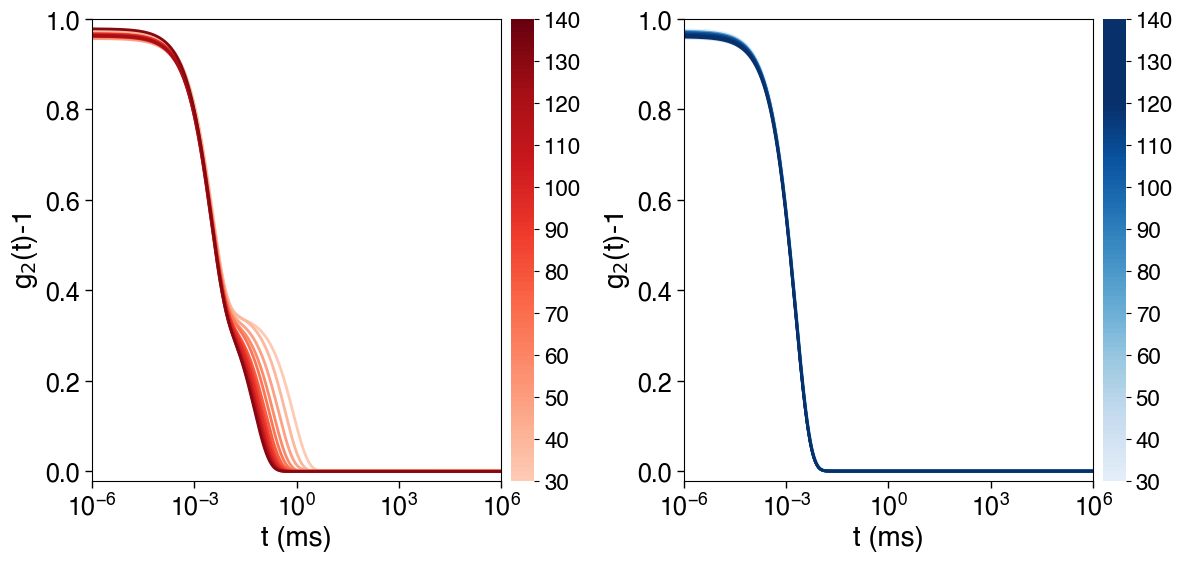


VV Fitting Results:
    Angle     A1     A2        B Gamma_t Gamma_mix    R^2
0      30 0.6200 0.3467 4.00e-04    1.25    297.79 0.9996
1      40 0.6163 0.3564 0.00e+00    2.15    305.42 0.9996
2      50 0.6035 0.3500 2.50e-03    3.37    310.47 0.9997
3      60 0.6067 0.3520 2.00e-04    4.81    312.77 0.9998
4      70 0.6049 0.3569 6.00e-04    6.44    319.40 0.9998
5      80 0.6077 0.3525 8.00e-04    8.19    324.35 0.9998
6      90 0.6063 0.3604 3.00e-04    9.88    329.83 0.9998
7     100 0.6013 0.3641 5.00e-04   11.61    331.98 0.9998
8     110 0.6005 0.3636 2.00e-04   13.45    336.26 0.9999
9     120 0.5985 0.3621 2.00e-04   14.93    339.49 0.9999
10    130 0.5968 0.3660 0.00e+00   16.40    340.02 0.9999
11    140 0.6061 0.3712 3.00e-04   17.40    337.98 0.9998

VH Fitting Results:
    Angle     A3       BB Gamma_mix    R^2
0      30 0.9744 1.00e-03    508.81 0.9997
1      40 0.9564 1.10e-03    516.24 0.9998
2      50 0.9641 1.10e-03    521.14 0.9998
3      60 0.9681 1.00e-03    524

In [9]:
# Fit the data and show the fitting lines

def gVV(tau, A1, A2, B, Gamma_t, delta):
    Gamma_mix = Gamma_t + np.abs(delta)  # Ensure Gamma_mix is always greater than Gamma_t
    return A1 * np.exp(-Gamma_mix * tau) + A2 * np.exp(-Gamma_t * tau) + B

def gVH(tau, A3, BB, Gamma_mix):
    return A3 * np.exp(-Gamma_mix * tau) + BB

# Prepare DataFrames to store results
columns_VV = ['Angle', 'A1', 'A2', 'B', 'Gamma_t', 'Gamma_mix', 'R^2']
results_VV = []

columns_VH = ['Angle', 'A3', 'BB', 'Gamma_mix', 'R^2']
results_VH = []

fig, axs = plt.subplots(1, 2, figsize=(14, 6))


# Plot and fit gVV data
ax1 = axs[0]
for idx, (x, y, label) in enumerate(zip(lagtime_VV, corrfx_VV, angles)):
    bounds = ([0, 0, 0, 0, -np.inf], 
              [np.inf, np.inf, np.inf, np.inf, np.inf])
    p0 = [1, 1, 1, 1, 1]
    try:
        popt, _ = curve_fit(gVV, x, y, p0=p0, bounds=bounds, maxfev=10000)
        A1, A2, B, Gamma_t, delta = popt
        Gamma_mix = Gamma_t + np.abs(delta)
        extended_x = np.logspace(-6, 6, 1000)
        fitting_y = gVV(extended_x, A1, A2, B, Gamma_t, delta)
        fitted_y = gVV(x, A1, A2, B, Gamma_t, delta)
        r_squared = r2_score(y, fitted_y)
        results_VV.append([label, round(A1, 4), round(A2, 4), round(B, 4), round(Gamma_t, 4), round(Gamma_mix, 4), round(r_squared, 4)])
        c = cmap_VV(float(idx) / len(lagtime_VV))
        ax1.plot(extended_x, fitting_y, color=c, linestyle='-', linewidth=2)
    except Exception as e:
        print(f"Error fitting curve for angle {label}: {e}")
        continue

sm_VV = plt.cm.ScalarMappable(cmap=cmap_VV)
sm_VV.set_array([])
cbar_VV = plt.colorbar(sm_VV, ax=ax1, orientation='vertical', pad=0.02)
cbar_VV.outline.set_visible(False)
ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VV.set_ticks(ticks)
cbar_VV.set_ticklabels(tick_labels, fontsize=16)

# Plot and fit gVH data
ax2 = axs[1]
for idx, (x, y, label) in enumerate(zip(lagtime_VH, corrfx_VH, angles)):
    popt, _ = curve_fit(gVH, x, y, maxfev=10000)
    A3, BB, Gamma_mix = popt
    extended_x = np.logspace(-6, 6, 1000)
    fitting_y = gVH(extended_x, *popt)
    fitted_y = gVH(x, *popt)
    r_squared = r2_score(y, fitted_y)
    results_VH.append([label, round(A3, 4), round(BB, 4), round(Gamma_mix, 4), round(r_squared, 4)])
    c = cmap_VH(float(idx) / len(lagtime_VH))
    ax2.plot(extended_x, fitting_y, color=c, linestyle='-', linewidth=2)

sm_VH = plt.cm.ScalarMappable(cmap=cmap_VH)
sm_VH.set_array([])
cbar_VH = plt.colorbar(sm_VH, ax=ax2, orientation='vertical', pad=0.02)
cbar_VH.outline.set_visible(False)
cbar_VH.set_ticks(ticks)
cbar_VH.set_ticklabels(tick_labels, fontsize=16)

# Configure axes
for ax in axs.flat:
    ax.set_xscale("log")
    ax.set_xlabel('t (ms)', fontsize=20)
    ax.set_ylabel('g$_2$(t)-1', fontsize=20)
    ax.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.set_xlim(1E-6, 1E6)
    ax.set_ylim(-0.02, 1)

plt.show()

# Convert results to DataFrames
df_VV = pd.DataFrame(results_VV, columns=columns_VV)
df_VH = pd.DataFrame(results_VH, columns=columns_VH)

print("\nVV Fitting Results:")
print(df_VV.to_string(formatters={'A1': '{:.4f}'.format, 'A2': '{:.4f}'.format, 'B': '{:.2e}'.format, 
                                   'Gamma_t': '{:.2f}'.format, 'Gamma_mix': '{:.2f}'.format, 'R^2': '{:.4f}'.format}))

print("\nVH Fitting Results:")
print(df_VH.to_string(formatters={'A3': '{:.4f}'.format, 'BB': '{:.2e}'.format, 
                                   'Gamma_mix': '{:.2f}'.format, 'R^2': '{:.4f}'.format}))


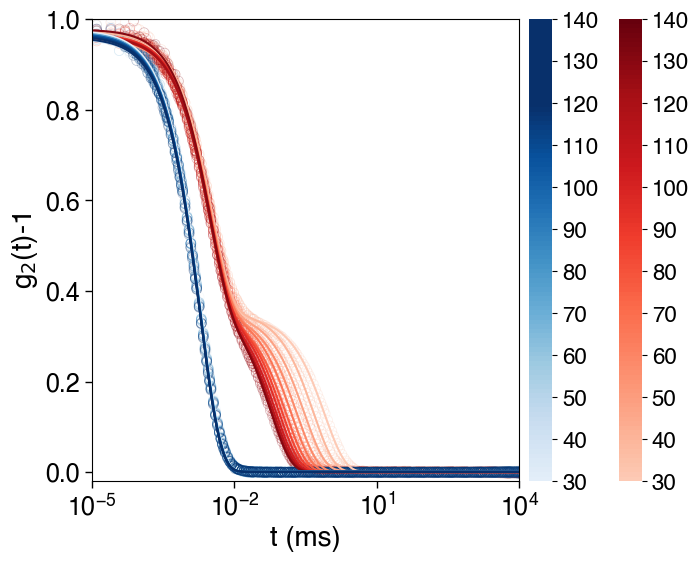

In [10]:
# Plot the measured data and fitted lines together

fig, axs = plt.subplots(figsize=(8,6))

for idx, (x, y, label) in enumerate(zip(lagtime_VV, corrfx_VV, angles)):
    # Perform curve fitting with bounds
    bounds = ([0, 0, -np.inf, 0, -np.inf], 
              [np.inf, np.inf, np.inf, np.inf, np.inf])  # Ensure Gamma_t and delta are positive
    p0 = [1, 1, 0, 1, 1]  # Initial guesses for A1, A2, B, Gamma_t, and delta
    try:
        popt, pcov = curve_fit(gVV, x, y, p0=p0, bounds=bounds, maxfev=10000)
    except Exception as e:
        print(f"Error fitting curve for angle {label}: {e}")
        continue

    # Extract parameters
    A1, A2, B, Gamma_t, delta = popt
    Gamma_mix = Gamma_t + np.abs(delta)
    
    # Generate extended x data
    extended_x = np.logspace(-6, 6, 1000)
    
    # Generate fitting y data
    fitting_y = gVV(extended_x, A1, A2, B, Gamma_t, delta)
    
    # Calculate R² value
    fitted_y = gVV(x, A1, A2, B, Gamma_t, delta)
    r_squared = r2_score(y, fitted_y)
    
    c = cmap_VV(float(idx) / len(lagtime_VV))
    scatter1 = axs.scatter(x, y,marker='o', facecolors=c, edgecolors=c, alpha=0.3,
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')
    # Plot fitting data
    axs.plot(extended_x, fitting_y, color=c, linestyle='-', linewidth=1.5)

sm_VV = plt.cm.ScalarMappable(cmap=cmap_VV)
sm_VV.set_array([])
cbar_VV = plt.colorbar(sm_VV, ax=axs, orientation='vertical', pad=0.02)
cbar_VV.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VV.set_ticks(ticks)
cbar_VV.set_ticklabels(tick_labels, fontsize=16)
for idx, (x, y, label) in enumerate(zip(lagtime_VH, corrfx_VH, angles)):
    # Perform curve fitting without constraints
    popt, pcov = curve_fit(gVH, x, y, maxfev=10000)
    
    # Generate extended x data
    extended_x = np.logspace(-6, 6, 1000)
    
    # Generate fitting y data
    fitting_y = gVH(extended_x, *popt)
    
    # Calculate R² value
    fitted_y = gVH(x, *popt)
    r_squared = r2_score(y, fitted_y)
    
    c = cmap_VH(float(idx) / len(lagtime_VH))
    
    scatter1 = axs.scatter(x, y,marker='o', facecolors=c, edgecolors=c, alpha=0.3,
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')

    axs.plot(extended_x, fitting_y, color=c, linestyle='-', linewidth=1.5)

sm_VH = plt.cm.ScalarMappable(cmap=cmap_VH)
sm_VH.set_array([])
cbar_VH = plt.colorbar(sm_VH, ax=axs, orientation='vertical', pad=0.02)
cbar_VH.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VH.set_ticks(ticks)
cbar_VH.set_ticklabels(tick_labels, fontsize=16)

axs.set_xscale("log")
axs.set_xlabel('t (ms)', fontsize=20)
axs.set_ylabel('g$_2$(t)-1', fontsize=20)
#ax.legend(frameon=False, loc='best', fontsize=16)
axs.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
axs.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
axs.set_xlim(1E-5, 1E4)
axs.set_ylim(-0.02, 1)
#plt.savefig("Correlation function VS lag time DLS vs DDLS fit.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

$$
\Gamma_t = D_t q^2
$$

where
$$
q = \frac{4\pi n}{\lambda}sin(\frac{\theta}{2})
$$

$$
\Gamma_r = 6D_r
$$

$$
\Gamma = \Gamma_t+\Gamma_r = q^2D_T+6D_R
$$
\
$D_T$ = Translational diffusion coefficient 
\
$D_R$ = Rotational diffusion coefficient 

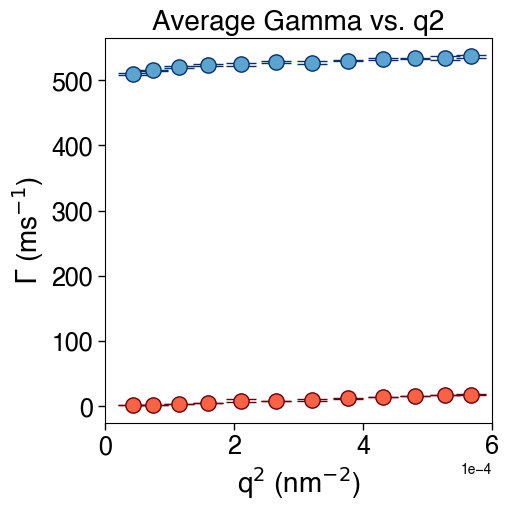

In [11]:
# Calculate q^2 from the measured angles
# Plot the fitted decay coefficients or gamma_mix and gamma_t
# All three measured data sets were fitted the data and used to plot here 

angle_rad = [np.deg2rad(x) for x in angles]
n = 1.33
lambd = 660 #nm

q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in angle_rad]
q2 = [x**2 for x in q]
q2_2 = ['{:.6f}'.format(x) for x in q2]

fig, ax = plt.subplots(figsize=(5, 5))
plt.errorbar(q2, average_gammas_VV, yerr=std_gammas_VV, fmt='o', markersize=11, capsize=11, linewidth=2, markerfacecolor=cmap_VV(0.4), markeredgecolor=cmap_VV(0.99), color=cmap_VV(0.99))
plt.errorbar(q2, average_gammas_VH, yerr=std_gammas_VH, fmt='o', markersize=11, capsize=11, linewidth=2, markerfacecolor=cmap_VH(0.4), markeredgecolor=cmap_VH(0.99), color=cmap_VH(0.99))

plt.xlabel('q$^2$ (nm$^{-2}$)', fontsize=20)
plt.ylabel('$\Gamma$ (ms$^{-1}$)', fontsize=20)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.xaxis.set_major_formatter(formatter)
plt.xlim(0, 6E-4)
#plt.ylim(0, 600)
plt.title('Average Gamma vs. q2', fontsize=20)
plt.show()

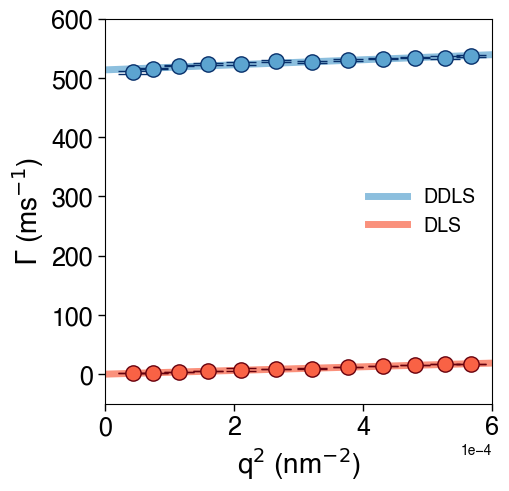

D_t from DLS (VV): 31114.40 nm^2/ms
D_t from DDLS (VH): 42844.46 nm^2/ms
D_r from DDLS (VH): 85.61 1/ms


In [12]:
# Fit the linear lines \Gamma = \Gamma_t+\Gamma_r = q^2D_T+6D_R to obtain D_t and D_r

def linear_fit_VV(q_sq, D_t_VV, B): 
    return D_t_VV * q_sq + B

popt_VV, pcov_VV = curve_fit(linear_fit_VV, q2, average_gammas_VV)
D_t_VV = popt_VV[0]


def linear_fit_VH(q_sq, D_t_VH, D_r_VH):
    return D_t_VH * q_sq + 6 * D_r_VH 

popt_VH, pcov_VH = curve_fit(linear_fit_VH, q2, average_gammas_VH)
D_t_VH = popt_VH[0]
D_r_VH = popt_VH[1]

extrapolated_q2 = np.linspace(0, 0.0006, 100)
extrapolated_gammas_VV = linear_fit_VV(extrapolated_q2, *popt_VV)
extrapolated_gammas_VH = linear_fit_VH(extrapolated_q2, *popt_VH)

q2 = np.array(q2)
fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(extrapolated_q2, extrapolated_gammas_VH, '-', linewidth=5, alpha=0.7, color=cmap_VH(0.4), label='DDLS')
plt.errorbar(q2, average_gammas_VH, yerr=std_gammas_VH, fmt='o', markersize=11, capsize=11, linewidth=2, markerfacecolor=cmap_VH(0.4), markeredgecolor=cmap_VH(0.99), color=cmap_VH(0.99))

#plt.plot(q2, linear_fit_VV(q2, *popt_VV), color=c_l_DLS, label='DLS')
plt.plot(extrapolated_q2, extrapolated_gammas_VV, '-', linewidth=5, alpha=0.7, color=cmap_VV(0.4), label='DLS')
plt.errorbar(q2, average_gammas_VV, yerr=std_gammas_VV, fmt='o', markersize=11, capsize=11, linewidth=2, markerfacecolor=cmap_VV(0.4), markeredgecolor=cmap_VV(0.99), color=cmap_VV(0.99))

plt.xlabel('q$^2$ (nm$^{-2}$)', fontsize=20)
plt.ylabel('$\Gamma$ (ms$^{-1}$)', fontsize=20)
plt.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
formatter = ScalarFormatter()
formatter.set_powerlimits((-4, -4))  
ax.xaxis.set_major_formatter(formatter)
plt.xlim(0, 6E-4)
plt.ylim(-50, 600)
#plt.title('Average Gamma vs. q2', fontsize=20)
plt.legend(frameon = False, fontsize=14)
#42,84plt.savefig("Gamma VS q^2 DLS vs DDLS.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

print(f'D_t from DLS (VV): {D_t_VV:.2f} nm^2/ms')
print(f'D_t from DDLS (VH): {D_t_VH:.2f} nm^2/ms')
print(f'D_r from DDLS (VH): {D_r_VH:.2f} 1/ms')

# Plotting differently

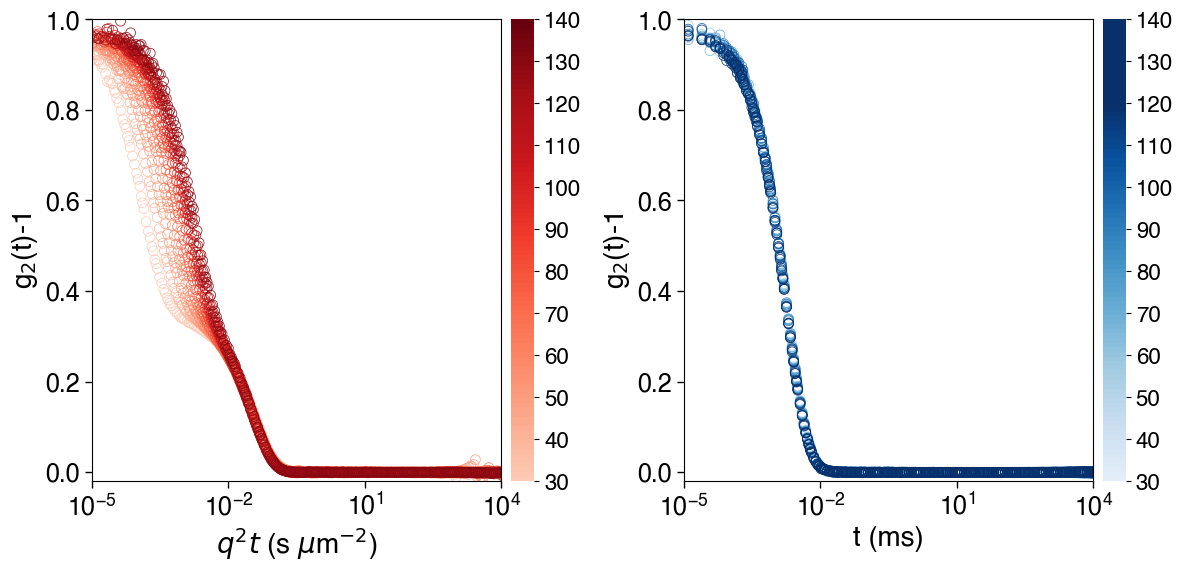

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

cmap_VV_0 = plt.get_cmap('Reds')
cmap_VV = ListedColormap(cmap_VV_0(np.linspace(0.2, 1.0, 100)))
cmap_VH_0 = plt.get_cmap('Blues')
cmap_VH = ListedColormap(cmap_VH_0(np.linspace(0.1, 1.2, 100)))

ax1 = axs[0]
for idx, (x, y, label, q2_val) in enumerate(zip(lagtime_VV, corrfx_VV, angles, q2)):
    x_new = x * q2_val * 1000  # Adjust x values
    c = cmap_VV(float(idx) / len(lagtime_VV))
    scatter1 = ax1.scatter(x_new, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')

sm_VV = plt.cm.ScalarMappable(cmap=cmap_VV)
sm_VV.set_array([])
cbar_VV = plt.colorbar(sm_VV, ax=ax1, orientation='vertical', pad=0.02)
cbar_VV.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VV.set_ticks(ticks)
cbar_VV.set_ticklabels(tick_labels, fontsize=16)

ax2 = axs[1]
for idx, (x, y, label) in enumerate(zip(lagtime_VH, corrfx_VH, angles)):
    c = cmap_VH(float(idx) / len(lagtime_VH))
    scatter1 = ax2.scatter(x, y,marker='o', facecolors=c, edgecolors=c, 
                          s=50, linewidths=0.5, label=label)
    scatter1.set_facecolor('none')

sm_VH = plt.cm.ScalarMappable(cmap=cmap_VH)
sm_VH.set_array([])
cbar_VH = plt.colorbar(sm_VH, ax=ax2, orientation='vertical', pad=0.02)
cbar_VH.outline.set_visible(False)

ticks = np.linspace(0, 1, len(angles))
tick_labels = angles
cbar_VH.set_ticks(ticks)
cbar_VH.set_ticklabels(tick_labels, fontsize=16)

ax1.set_xlabel(r'$q^2 t$ (s $\mu$m$^{-2}$)', fontsize=20)
ax2.set_xlabel('t (ms)', fontsize=20)
ax2.set_xlim(1E-5, 1E4)
ax1.set_xlim(1E-5, 1E4)
for ax in axs.flat:
    ax.set_xscale("log")
    ax.set_ylabel('g$_2$(t)-1', fontsize=20)
    ax.tick_params(axis='y', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.tick_params(axis='x', length=5, width=1, color='black', direction='out', labelsize=18)
    ax.set_ylim(-0.02, 1)
# plt.savefig("Correlation function VS lag time DLS vs DDLS.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()


# Shape determinations with the diffusion coefficients

## Generalized equations for spherical nanoparticles
$$
D_T = \frac{k_B T }{6\pi \eta} \frac{1}{R}
$$

$$
D_R = \frac{k_B T }{8\pi \eta}  \frac{1}{R^3}
$$

## Generalized equations for straight cylinders
$$
D_T = \frac{k_B T }{3\pi \eta L} f(\frac{L}{r})
$$

$$
D_R = \frac{3k_B T }{\pi \eta L^3}  f(\frac{L}{r})
$$

### 1st Method - a model proposed for rods with r << L
#### A. Wada; N. C. Ford, Jr.; F. E. Karasz, J. Chem. Phys. 55, 1798 (1971)
##### The same method presented by LS instrument 
$$
D_T = \frac{k_B T }{6\pi \eta L} ln(\frac{L}{r})
$$

$$
D_R = \frac{k_B T }{8\pi \eta L^3} ln(\frac{L}{r})
$$

Rearrange the equations:

$$
D_R = \frac{6}{8} {\frac{k_B T }{6\pi \eta} \frac{ln(L/r)}{L}} \frac{1}{L^2}
$$

$$
D_R = \frac{3}{4} D_T \frac{1}{L^2}
$$

$$
L^2 = \frac{3}{4} \frac{D_T}{D_R}
$$

$$
ln(L/r) = D_T \frac{6\pi \eta L}{k_B T}
$$

$$
\frac{L}{r} = exp(D_T \frac{6\pi \eta L}{k_B T})
$$

$$
r = \frac{L}{exp(D_T \frac{6\pi \eta L}{k_B T})}
$$

In [14]:
D_t = D_t_VV*1e-18/1e-3   #m^2/s
D_r = D_r_VH/1e-3         #1/s
eta = 0.9321e-3              #Pa*s
T_C = 23                  #C
T_K = T_C+273             #K
pi = np.pi
                          #1 Joule = 1 Pa.m3
kB = 1.38e-23             #J/K = Pa.m3/K
L = np.sqrt((3*D_t)/(4*D_r))
L_nm = L*1e9
print(f"L= {L_nm:.2f} nm")

#ln_L_r = (D_r * 8 * pi * eta * L**3) / (kB * T_K)
ln_L_r = (D_t * 6 * pi * eta * L) / (kB * T_K)
AR = np.exp(ln_L_r)
r = L / AR
r_nm = r*1e9
print(f"r= {r_nm:.2f} nm")

print(f"Aspect ratio: {AR:.2f}\n") 

err_L = (abs(31.9-L_nm)/31.9)*100
print(f"%err L = {err_L:.2f}%")
err_w = (abs(13.1-r_nm)/13.1)*100
print(f"%err r = {err_w:.2f}%")
err_ar = (abs(2.49-AR)/2.49)*100
print(f"%err AR = {err_ar:.2f}%")

L= 16.51 nm
r= 1.81 nm
Aspect ratio: 9.11

%err L = 48.24%
%err r = 86.17%
%err AR = 265.94%


### 2nd Method - A model used for short DNA fragments
#### M. Mercedes Tirado; Carmen López Martínez; José García de la Torre, J. Chem. Phys. 81, 2047–2052 (1984)

$$
D_T = \frac{k_B T }{3\pi \eta L} [ln(\frac{L}{D})+\gamma_t]
$$

$$
D_R = \frac{3k_B T }{\pi \eta L^3} [ln(\frac{L}{D})+\gamma_r]
$$

For rod-like macromolecules: $\gamma_t$ and $\gamma_r$ are experimental values 

$$
\gamma_t \sim 0.312
$$

$$
\gamma_r \sim -0.446
$$

$$
D_T = \frac{k_B T }{3\pi \eta L} [ ln(\frac{L}{D}) + 0.312]
$$

$$
D_R = \frac{3k_B T }{\pi \eta L^3} [ ln(\frac{L}{D}) - 0.446]
$$

In [15]:
eta = 0.9321e-3  # Pa*s
T_C = 23         # Celsius
T_K = T_C + 273  # Kelvin
kB = 1.38e-23    # J/K = Pa*m^3/K

D_t = D_t_VV*1e-18/1e-3  
D_r = D_r_VH/1e-3   

def equations(vars):
    L, D = vars
    eq1 = (kB * T_K / (3 * eta * L)) * (ln(L / D) + 0.312) - D_t
    eq2 = (3 * kB * T_K / (eta * L**3)) * (ln(L / D) - 0.446) - D_r
    return [eq1, eq2]

initial_guess = [1e-9, 1e-10]

result = least_squares(equations, initial_guess, bounds=([0, 0], [np.inf, np.inf]))

L, D = result.x

AR = L/D
print(f"L = {L*1e9:.2f} nm")
print(f"D = {D*1e9:.2f} nm")
print(f"Aspect ratio: {AR:.2f}\n") 

err_L = (abs(31.9-L*1e9)/31.9)*100
print(f"%err L = {err_L:.2f}%")
err_w = (abs(13.1-D*1e9)/13.1)*100
print(f"%err w = {err_w:.2f}%")
err_ar = (abs(2.49-AR)/2.49)*100
print(f"%err AR = {err_ar:.2f}%")

L = 41.95 nm
D = 16.61 nm
Aspect ratio: 2.53

%err L = 31.49%
%err w = 26.77%
%err AR = 1.44%


### 3rd Method - Rg and Rh determinations

Hydrodynamic radius ($R_h$)
$$ 
R_h = \frac{kT}{6\pi \eta D}
$$

Radius of Gyration ($R_g$)

For spheres: 
$$ 
R_g^2 = \frac{3}{5}R^2
$$

For cylinders: 
$$ 
R_g^2 = \frac{R^2}{2}+\frac{h^2}{12}
$$

The ratio $R_g$/$R_h$

For spheres: 
$$ 
R_g/R_h = 0.775
$$
For hollow spheres: 
$$ 
R_g/R_h = 1
$$
For rigid rods: 
$$ 
R_g/R_h > 2
$$


In [16]:
# Find Rh 
# Only use D_t from the two modes

Rh_DLS = (kB*T_K)/(6*pi*eta*D_t_VV*1e-18/1e-3) 
Rh_DLS_nm = Rh_DLS*1e9
print(f'Dt_DLS = {D_t_VV:.2e} nm^2/ms = {D_t_VV*1e3:.2e} nm^2/s')
print(f"Rh_DLS = {Rh_DLS_nm:.2f} nm")

Rh_DDLS = (kB*T_K)/(6*pi*eta*D_t_VH*1e-18/1e-3) 
Rh_DDLS_nm = Rh_DDLS*1e9
print(f"Dt_DDLS = {D_t_VH:.2e} nm^2/ms = {D_t_VH*1e3:.2e} nm^2/s")
print(f"Rh_DDLS = {Rh_DDLS_nm:.2f} nm")

Dt_DLS = 3.11e+04 nm^2/ms = 3.11e+07 nm^2/s
Rh_DLS = 7.47 nm
Dt_DDLS = 4.28e+04 nm^2/ms = 4.28e+07 nm^2/s
Rh_DDLS = 5.43 nm


In [17]:
# Find Rg
AuNRs_SLS = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VV/Au NRs_0.1OD.csv', header= None, skiprows=[0,1,2,3])

AuNRs_SLS_theta_angle = AuNRs_SLS.iloc[3:,13]
AuNRs_SLS_I_wave = AuNRs_SLS.iloc[3:,4]
AuNRs_SLS_theta = [float(theta) for theta in AuNRs_SLS_theta_angle]
AuNRs_SLS_theta_radian = np.deg2rad(AuNRs_SLS_theta)
AuNRs_SLS_I = [float(I) for I in AuNRs_SLS_I_wave]
AuNRs_SLS_lnI = [np.log(I) for I in AuNRs_SLS_I]

n = 1.33
lambd = 660 #nm

AuNRs_SLS_q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in AuNRs_SLS_theta_radian]
AuNRs_SLS_q2 = [q**2 for q in AuNRs_SLS_q]

AuNRs_SLS_DD = pd.read_csv('/Users/ningravi/Desktop/Python/RawData/20240717_DDLS on AuNRs/Au NRs_0.1OD_VH/Au NRs_0.1OD_VH.csv', header= None, skiprows=[0,1,2,3])

AuNRs_SLS_DD_theta_angle = AuNRs_SLS_DD.iloc[3:,13]
AuNRs_SLS_DD_I_wave = AuNRs_SLS_DD.iloc[3:,4]
AuNRs_SLS_DD_theta = [float(theta) for theta in AuNRs_SLS_DD_theta_angle]
AuNRs_SLS_DD_theta_radian = np.deg2rad(AuNRs_SLS_DD_theta)
AuNRs_SLS_DD_I = [float(I) for I in AuNRs_SLS_DD_I_wave]
AuNRs_SLS_DD_lnI = [np.log(I) for I in AuNRs_SLS_DD_I]

AuNRs_SLS_DD_q = [(4*np.pi*n*np.sin(x/2))/(lambd) for x in AuNRs_SLS_DD_theta_radian]
AuNRs_SLS_DD_q2 = [q**2 for q in AuNRs_SLS_DD_q]

##### The chracteristis of objects are encoded in the low q scattering via radius of gyration calculated as the root mean square distance of the object's parts from its center of gravity.


Guinier Law (valid when $qR_g<1.3$):

$$
I(q→0)\sim I_0 exp(\frac{−q^2R_g^2}{3})
$$

Linearize it

$$
ln⁡(𝐼(𝑞)) ≈ −\frac{𝑞^2 𝑅_𝑔^2}{3}+ln(⁡𝐼(0))
$$

Or
$$
𝑃(𝑞)≃1−\frac{(𝑞𝑅_𝑔 )^2}{3}
$$

Note: the Guinier region of the scattering data would not be linear if sample contains aggregation
    

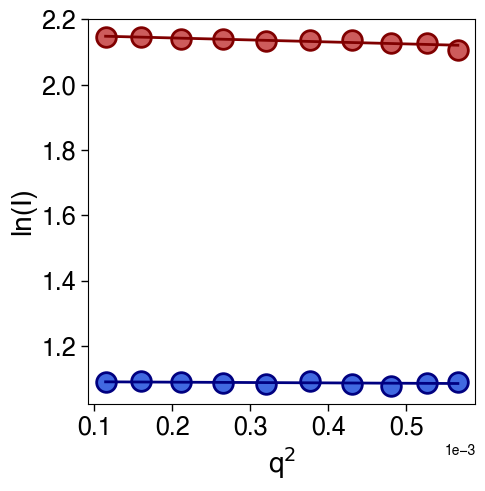

DLS:
 Rg^2 = 60.90
 ln(I0) = 2.15
 R2 = 0.7319
DDLS:
 Rg^2 = 11.35
 ln(I0) = 1.09
 R2 = 0.1344


In [18]:
def linear_equation(x, m, c):
    return m * x + c

popt_AuNRs_SLS, pcov_AuNRs_SLS = curve_fit(linear_equation, AuNRs_SLS_q2, AuNRs_SLS_lnI)

slope_AuNRs_SLS, intercept_AuNRs_SLS = popt_AuNRs_SLS

x_AuNRs_SLS = np.linspace(min(AuNRs_SLS_q2), max(AuNRs_SLS_q2), 100)
y_AuNRs_SLS = slope_AuNRs_SLS * x_AuNRs_SLS + intercept_AuNRs_SLS

AuNRs_SLS_q2 = np.array(AuNRs_SLS_q2)

y_pred_AuNRs_SLS = linear_equation(AuNRs_SLS_q2, slope_AuNRs_SLS, intercept_AuNRs_SLS)

r_squared_AuNRs_SLS = r2_score(AuNRs_SLS_lnI, y_pred_AuNRs_SLS[:len(AuNRs_SLS_lnI)])

fig, ax = plt.subplots(figsize=(5, 5))

PS_scatter = ax.scatter(AuNRs_SLS_q2, AuNRs_SLS_lnI, s=200, alpha=1, marker='o', 
                        facecolors='indianred', edgecolors='maroon', linewidths=2, clip_on=False)
#PS_scatter.set_facecolor('none')

ax.plot(x_AuNRs_SLS, y_AuNRs_SLS, color='maroon', linestyle='-', linewidth=2)

popt_AuNRs_SLS_DD, pcov_AuNRs_SLS_DD = curve_fit(linear_equation, AuNRs_SLS_DD_q2, AuNRs_SLS_DD_lnI)

slope_AuNRs_SLS_DD, intercept_AuNRs_SLS_DD = popt_AuNRs_SLS_DD

x_AuNRs_SLS_DD = np.linspace(min(AuNRs_SLS_DD_q2), max(AuNRs_SLS_DD_q2), 100)
y_AuNRs_SLS_DD = slope_AuNRs_SLS_DD * x_AuNRs_SLS_DD + intercept_AuNRs_SLS_DD

AuNRs_SLS_DD_q2 = np.array(AuNRs_SLS_DD_q2)

y_pred_AuNRs_SLS_DD = linear_equation(AuNRs_SLS_DD_q2, slope_AuNRs_SLS_DD, intercept_AuNRs_SLS_DD)

r_squared_AuNRs_SLS_DD = r2_score(AuNRs_SLS_DD_lnI, y_pred_AuNRs_SLS_DD[:len(AuNRs_SLS_DD_lnI)])


PS_scatter = ax.scatter(AuNRs_SLS_DD_q2, AuNRs_SLS_DD_lnI, s=200, alpha=1, marker='o', 
                        facecolors='royalblue', edgecolors='navy', linewidths=2, clip_on=False)
#PS_scatter.set_facecolor('none')

ax.plot(x_AuNRs_SLS_DD, y_AuNRs_SLS_DD, color='navy', linestyle='-', linewidth=2)

plt.xlabel('q$^2$', fontsize=20)
plt.ylabel('ln(I)', fontsize=20)  

formatter = ScalarFormatter()
formatter.set_powerlimits((-3, -3))  
ax.xaxis.set_major_formatter(formatter)

plt.tick_params(axis='y', length=5, width=1, color='black', direction='out')
plt.tick_params(axis='x', length=5, width=1, color='black', direction='out')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.ylim(3.85, 4.15)
#plt.xlim(0, 0.0006)
#plt.text(0.3e-3, 2.12, f"Slope: {slope_AuNRs_SLS:.1f}\ny-intercept: {intercept_AuNRs_SLS:.1f}\nR$^2$ = {r_squared_AuNRs_SLS:.2f}",
#         fontsize=14, c='red')
#plt.savefig("Rg determinstion.png", dpi=1500, bbox_inches='tight', transparent=True)
plt.show()

print(f"DLS:\n Rg^2 = {-slope_AuNRs_SLS:.2f}\n ln(I0) = {intercept_AuNRs_SLS:.2f}\n R2 = {r_squared_AuNRs_SLS:.4f}")
print(f"DDLS:\n Rg^2 = {-slope_AuNRs_SLS_DD:.2f}\n ln(I0) = {intercept_AuNRs_SLS_DD:.2f}\n R2 = {r_squared_AuNRs_SLS_DD:.4f}")

In [19]:
# Consider as both to be spherical
AuNRs_SLS_Rg = np.sqrt(-slope_AuNRs_SLS * 3)

print(f"AuNRs Rg: {AuNRs_SLS_Rg:.2f} nm")

R_AuNRs_SLS = np.sqrt(5/3*AuNRs_SLS_Rg**2)
D_AuNRs_SLS = 2*R_AuNRs_SLS
print(f"R: {R_AuNRs_SLS:.2f} nm")
print(f"D: {D_AuNRs_SLS:.2f} nm\n")

AuNRs_SLS_DD_Rg = np.sqrt(-slope_AuNRs_SLS_DD * 3)

print(f"AuNRs Rg: {AuNRs_SLS_DD_Rg:.2f} nm")

R_AuNRs_SLS_DD = np.sqrt(5/3*AuNRs_SLS_DD_Rg**2)
D_AuNRs_SLS_DD = 2*R_AuNRs_SLS_DD
print(f"R: {R_AuNRs_SLS_DD:.2f} nm")
print(f"D: {D_AuNRs_SLS_DD:.2f} nm\n")

AR = D_AuNRs_SLS/D_AuNRs_SLS_DD
print(f"Aspect ratio: {AR:.2f}")

err_L = (abs(31.9 - D_AuNRs_SLS)/31.9)*100
print(f"%err L= {err_L:.2f}%")
err_w = (abs(13.1 - D_AuNRs_SLS_DD)/13.1)*100
print(f"%err D = {err_w:.2f}%")
err_ar = (abs(2.49-AR)/2.49)*100
print(f"%err AR = {err_ar:.2f}%")

AuNRs Rg: 13.52 nm
R: 17.45 nm
D: 34.90 nm

AuNRs Rg: 5.84 nm
R: 7.53 nm
D: 15.07 nm

Aspect ratio: 2.32
%err L= 9.40%
%err D = 15.03%
%err AR = 6.99%


In [20]:
# Find the shape from Rg/Rh

shape_DLS = AuNRs_SLS_Rg/Rh_DLS_nm
print(f"DLS")
print(f"Rg = {AuNRs_SLS_Rg:.2f} nm")
print(f"Rh = {Rh_DLS_nm:.2f} nm")
print(f'Rg/Rh = {shape_DLS:.2f}\n')

shape_DDLS = AuNRs_SLS_DD_Rg/Rh_DDLS_nm
print(f"DDLS")
print(f"Rg = {AuNRs_SLS_DD_Rg:.2f} nm")
print(f"Rh = {Rh_DDLS_nm:.2f} nm")
print(f'Rg/Rh = {shape_DDLS:.2f}')

DLS
Rg = 13.52 nm
Rh = 7.47 nm
Rg/Rh = 1.81

DDLS
Rg = 5.84 nm
Rh = 5.43 nm
Rg/Rh = 1.08


In [21]:
# Consider as spherical shape for DDLS and cylindrical shape for DLS

hw_AuNRs_SLS_DD = np.sqrt(5/3*AuNRs_SLS_DD_Rg**2)
w_AuNRs_SLS_DD = 2*R_AuNRs_SLS_DD
print(f"Half width = {hw_AuNRs_SLS_DD:.2f} nm")
print(f"Width = {w_AuNRs_SLS_DD:.2f} nm\n")

l_AuNRs_SLS = np.sqrt(12*(((AuNRs_SLS_Rg**2))-((R_AuNRs_SLS_DD**2)/2)))
print(f"Length = {l_AuNRs_SLS:.2f} nm\n")

AR = l_AuNRs_SLS/w_AuNRs_SLS_DD
print(f"Aspect ratio: {AR:.2f}\n")

err_L = (abs(31.9-l_AuNRs_SLS)/31.9)*100
print(f"%err L = {err_L:.2f}%")
err_w = (abs(13.1-w_AuNRs_SLS_DD)/13.1)*100
print(f"%err w = {err_w:.2f}%")
err_ar = (abs(2.49-AR)/2.49)*100
print(f"%err AR = {err_ar:.2f}%")

Half width = 7.53 nm
Width = 15.07 nm

Length = 43.03 nm

Aspect ratio: 2.86

%err L = 34.89%
%err w = 15.03%
%err AR = 14.69%


# References

Source: Directly provided by the vendor from NanoComposix


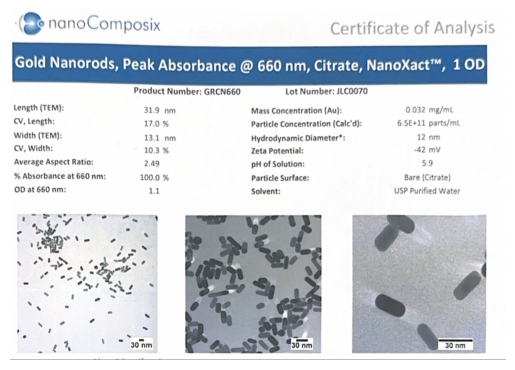

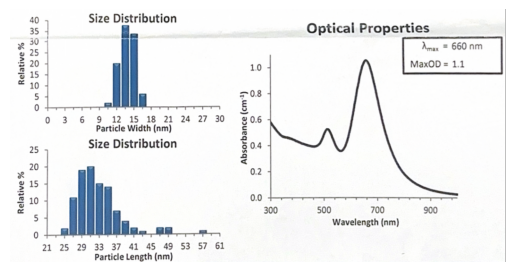

In [22]:
print("Source: Directly provided by the vendor from NanoComposix")

img = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Au NR.png')

plt.imshow(img)
plt.axis('off')  
plt.show()

img = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Au NR 2.png')

plt.imshow(img)
plt.axis('off')  
plt.show()


Source: Benoit Maxit, Clara Catros, Florian Aubrit, Julien Le Mener, Olivier Sandre, et al New methodology for anisotropic nanoparticles characterization by polarization light scattering: length and diameter determination of rod-like nanoparticles. Conference of Science & Technology for Integrated Circuits (CSTIC2024) – Symposium VI: Metrology, Reliability and Testing, SEMICON China, Mar 2024, Shanghai (Chine), China. hal-04263744v2


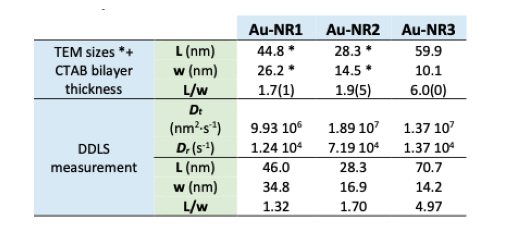

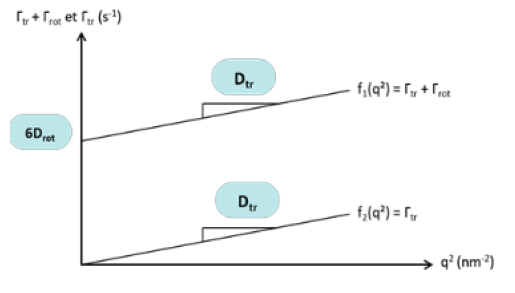

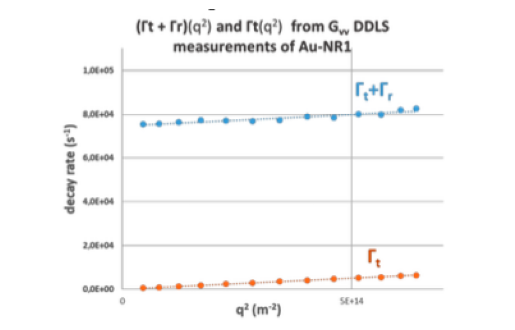

In [23]:
print('Source: Benoit Maxit, Clara Catros, Florian Aubrit, Julien Le Mener, Olivier Sandre, et al New methodology for anisotropic nanoparticles characterization by polarization light scattering: length and diameter determination of rod-like nanoparticles. Conference of Science & Technology for Integrated Circuits (CSTIC2024) – Symposium VI: Metrology, Reliability and Testing, SEMICON China, Mar 2024, Shanghai (Chine), China. hal-04263744v2')

img = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Screenshot 2024-06-20 at 11.16.31 AM.png')

plt.imshow(img)
plt.axis('off')  
plt.show()
img2 = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Screenshot 2024-06-20 at 11.16.42 AM.png')
plt.imshow(img2)
plt.axis('off')  
plt.show()
img3 = mpimg.imread('/Users/ningravi/Desktop/Python/Miscell plots/Screenshot 2024-06-20 at 11.16.50 AM.png')
plt.imshow(img3)
plt.axis('off')  
plt.show()
